# testing model architectures
check models compile okay

In [1]:
import torch
import numpy as np
from torchinfo import summary
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [10]:
from trustworthai.models.base_models.kiUNets import SimpleBlock, FullyConvolutionalAutoEncoder, KiUNetWithTranspose, KiUNet3D, block_list

In [3]:
encoder_block = SimpleBlock(2, 32, 3, 0.1, False, True, dimensions=3)

In [4]:
summary(encoder_block, (1, 2, 48, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleBlock                              --                        --
├─Conv3d: 1-1                            [1, 32, 48, 128, 128]     1,760
├─BatchNorm3d: 1-2                       [1, 32, 24, 64, 64]       64
├─Dropout3d: 1-3                         [1, 32, 24, 64, 64]       --
Total params: 1,824
Trainable params: 1,824
Non-trainable params: 0
Total mult-adds (G): 1.38
Input size (MB): 6.29
Forward/backward pass size (MB): 226.49
Params size (MB): 0.01
Estimated Total Size (MB): 232.79

In [5]:
decoder_block = SimpleBlock(32, 3, 3, 0.1, True, False, dimensions=3)

In [6]:
summary(decoder_block, (8, 32, 12, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleBlock                              --                        --
├─ConvTranspose3d: 1-1                   [8, 3, 24, 128, 128]      2,595
├─BatchNorm3d: 1-2                       [8, 3, 24, 128, 128]      6
├─Dropout3d: 1-3                         [8, 3, 24, 128, 128]      --
Total params: 2,601
Trainable params: 2,601
Non-trainable params: 0
Total mult-adds (G): 8.16
Input size (MB): 50.33
Forward/backward pass size (MB): 150.99
Params size (MB): 0.01
Estimated Total Size (MB): 201.34

In [7]:
ae = FullyConvolutionalAutoEncoder()

In [8]:
summary(ae, (4, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
FullyConvolutionalAutoEncoder            --                        --
├─ModuleList: 1-1                        --                        --
├─ModuleList: 1-2                        --                        --
├─ModuleList: 1-1                        --                        --
│    └─SimpleBlock: 2-1                  [4, 64, 64, 64]           --
│    │    └─Conv2d: 3-1                  [4, 64, 128, 128]         1,792
│    │    └─BatchNorm2d: 3-2             [4, 64, 64, 64]           128
│    │    └─Dropout2d: 3-3               [4, 64, 64, 64]           --
│    └─SimpleBlock: 2-2                  [4, 128, 32, 32]          --
│    │    └─Conv2d: 3-4                  [4, 128, 64, 64]          73,856
│    │    └─BatchNorm2d: 3-5             [4, 128, 32, 32]          256
│    │    └─Dropout2d: 3-6               [4, 128, 32, 32]          --
│    └─SimpleBlock: 2-3                  [4, 256, 16, 16]          --
│    │

In [27]:
class TestKiUNet3D(nn.Module):
    # I have slightly adapted this to use transpose convolution layers as opposed to interpolation...
    # not sure if that is the best idea or not
    # the standard version (class below, uses interpolation like they do)
    def __init__(self, encoder_layers=[16,32,64], decoder_layers=[32,16,8], 
                 encoderf1_layers=[16,32,64], decoderf1_layers=[32,16,8], 
                 intere_layers=[16,32,64], interd_layers=[32,16],
                 in_channels=3, out_channels=1, kernel_size=3, dropout_p=0.5):
        super().__init__()
        self.kernel_size = kernel_size
        self.dropout_p = dropout_p
        dimensions = 3
        
        
        self.encoder_blocks = block_list([in_channels] + encoder_layers[:-1], encoder_layers,
                                        kernel_size, dropout_p, False, max_pooling=True, dimensions=dimensions)
        
        self.decoder_blocks = block_list([encoder_layers[-1]] + decoder_layers[:-1], decoder_layers,
                                        kernel_size, dropout_p, False, max_pooling=False, dimensions=dimensions)
        
        self.encoderf1_blocks = block_list([in_channels] + encoderf1_layers[:-1], encoderf1_layers,
                                          kernel_size, dropout_p, False, max_pooling=False, dimensions=dimensions)
        
        self.decoderf1_blocks = block_list([encoderf1_layers[-1]] + decoderf1_layers[:-1], decoderf1_layers,
                                          kernel_size, dropout_p, False, max_pooling=True, dimensions=dimensions)
        
        self.intere1_blocks = block_list(intere_layers, intere_layers, 
                                         kernel_size, dropout_p, False, max_pooling=False, dimensions=dimensions)
        
        self.intere2_blocks = block_list(intere_layers, intere_layers, 
                                         kernel_size, dropout_p, False, max_pooling=False, dimensions=dimensions)
        
        self.interd1_blocks = block_list(interd_layers, interd_layers, 
                                         kernel_size, dropout_p, False, max_pooling=False, dimensions=dimensions)
        
        self.interd2_blocks = block_list(interd_layers, interd_layers,
                                        kernel_size, dropout_p, False, max_pooling=False, dimensions=dimensions)
        
        self.final_conv = nn.Conv3d(8, out_channels=out_channels, kernel_size=1, stride=1, padding=0)
        self.soft = nn.Softmax(dim=1)
        
        mode = 'trilinear'
        self.upscale_ki = lambda x : F.interpolate(x, scale_factor=(1,2,2), mode=mode)
        self.upscale_u = lambda x : F.interpolate(x, scale_factor=2, mode=mode)
        
    def forward(self, x):
        
        unet_out = x
        kinet_out = x
        skip_conns_stack = []
        scale_factor = 1
        mode = 'trilinear'
        
        # encoder path
        num_blocks = len(self.encoder_blocks)
        for l in range(num_blocks):
            # standard forward pass for both paths
            unet_out = self.encoder_blocks[l](unet_out)
            kinet_out = self.upscale_ki(self.encoderf1_blocks[l](kinet_out))
            
            print("unet out shape: ", unet_out.shape)
            print("kinet out shape: ", kinet_out.shape)
            
            tmp = unet_out
            
            # CRFB block
            scale_factor *= 4.
            crfb1 = self.intere1_blocks[l](kinet_out)
            print("crbf unet out shape: ", crfb1.shape)
            unet_out = torch.add(
                unet_out,
                F.interpolate(crfb1, size=unet_out.size()[2:], scale_factor=None, mode=mode)
            )
            print("crbf add unet out shape: ", unet_out.shape)
            
            crfb2 = self.intere2_blocks[l](tmp)
            print("crbf kinet out shape: ", crfb2.shape)
            print(kinet_out.size())
            interpolated = F.interpolate(crfb2, size=kinet_out.size()[2:],scale_factor=None,mode=mode)
            print("interpolated shape: ", interpolated.shape)
            kinet_out = torch.add(
                kinet_out,
                interpolated
            )
            print("crbf add kinet out shape: ", kinet_out.shape)
            print()
            
            # append skip connections
            if l != num_blocks - 1:
                skip_conns_stack.append((unet_out, kinet_out))
            # print()
            
        print("decoder\n")
            
        # decoder path
        for l in range(len(self.decoder_blocks)):
            # standard forward pass for both paths
            unet_out = self.upscale_u(self.decoder_blocks[l](unet_out))
            kinet_out = self.decoderf1_blocks[l](kinet_out)
            
            print("unet out shape: ", unet_out.shape)
            print("kinet out shape: ", kinet_out.shape)
            
            tmp = unet_out
            
            # CRFB block
            if l != num_blocks - 1:
                scale_factor /= 4.
                crfb1 = self.interd1_blocks[l](kinet_out)
                print("crbf unet out shape: ", crfb1.shape)
                unet_out = torch.add(
                    unet_out,
                    F.interpolate(crfb1, size=unet_out.size()[2:], scale_factor=None, mode=mode)
                )
                print("crbf add unet out shape: ", unet_out.shape)

                crfb2 =self.interd2_blocks[l](tmp)
                print("crbf kinet out shape: ", crfb2.shape)
                print(kinet_out.size())
                interpolated = F.interpolate(crfb2, size=kinet_out.size()[2:], scale_factor=None, mode=mode)
                print("interpolated shape: ", interpolated.shape)
                kinet_out = torch.add(
                    kinet_out,
                    interpolated
                )
                print("crbf add kinet out shape: ", kinet_out.shape)
            print()
            
            # add skip connections
            if l != num_blocks - 1:
                unet_skipc, kinet_skipc = skip_conns_stack.pop() # pop implements LIFO stack behaviour
                print("skip size unet: ", unet_skipc.shape)
                print("skip size kinet: ", kinet_skipc.shape)
                print("unet size ", unet_out.shape)
                print("kinet size", kinet_out.shape)
                # do padding where the sizes don't match
                if unet_out.shape != unet_skipc.shape:
                    # print("using")
                    unet_out = pad_3D_tensors(unet_out, unet_skipc.shape)
                    # print("new unet shape: ", unet_out.shape)
                if kinet_out.shape != kinet_skipc.shape:
                    kinet_out = pad_3D_tensors(kinet_out, kinet_skipc.shape)
                unet_out = torch.add(unet_out, unet_skipc)
                kinet_out = torch.add(kinet_out, kinet_skipc)
            
        
        # fusion of both branches
        kinet_out = F.interpolate(kinet_out, scale_factor=(2,1,1), mode='trilinear')
        print("out_shapes: ", unet_out.shape, kinet_out.shape)
        if kinet_out.shape != unet_out.shape:
            unet_out = pad_3D_tensors(unet_out, kinet_out.shape)
        out = torch.add(unet_out, kinet_out)
        out = self.final_conv(out)
        out = self.soft(out)
        
        return out
    

def pad_3D_tensors(img, target_shape):
    img_shape = img.shape
    lr_diff = target_shape[-3] - img_shape[-3]
    top_bottom_diff = target_shape[-2] - img_shape[-2]
    front_back_diff = target_shape[-1] - img_shape[-1]
    l_pad = lr_diff // 2
    r_pad = lr_diff - l_pad
    top_pad = top_bottom_diff // 2
    bottom_pad = top_bottom_diff - top_pad
    front_pad = front_back_diff // 2
    back_pad = front_back_diff - front_pad
    
    #print((l_pad, r_pad, top_pad, bottom_pad, front_pad, back_pad))
    
    return F.pad(img, (front_pad, back_pad, top_pad, bottom_pad, l_pad, r_pad))

In [28]:
kiunet = TestKiUNet3D(in_channels=1)

In [30]:
summary(kiunet, (1, 1, 8, 15, 15))

unet out shape:  torch.Size([1, 16, 4, 7, 7])
kinet out shape:  torch.Size([1, 16, 8, 30, 30])
crbf unet out shape:  torch.Size([1, 16, 8, 30, 30])
crbf add unet out shape:  torch.Size([1, 16, 4, 7, 7])
crbf kinet out shape:  torch.Size([1, 16, 4, 7, 7])
torch.Size([1, 16, 8, 30, 30])
interpolated shape:  torch.Size([1, 16, 8, 30, 30])
crbf add kinet out shape:  torch.Size([1, 16, 8, 30, 30])

unet out shape:  torch.Size([1, 32, 2, 3, 3])
kinet out shape:  torch.Size([1, 32, 8, 60, 60])
crbf unet out shape:  torch.Size([1, 32, 8, 60, 60])
crbf add unet out shape:  torch.Size([1, 32, 2, 3, 3])
crbf kinet out shape:  torch.Size([1, 32, 2, 3, 3])
torch.Size([1, 32, 8, 60, 60])
interpolated shape:  torch.Size([1, 32, 8, 60, 60])
crbf add kinet out shape:  torch.Size([1, 32, 8, 60, 60])

unet out shape:  torch.Size([1, 64, 1, 1, 1])
kinet out shape:  torch.Size([1, 64, 8, 120, 120])
crbf unet out shape:  torch.Size([1, 64, 8, 120, 120])
crbf add unet out shape:  torch.Size([1, 64, 1, 1, 1])

Layer (type:depth-idx)                   Output Shape              Param #
TestKiUNet3D                             --                        --
├─ModuleList: 1-1                        --                        --
├─ModuleList: 1-2                        --                        --
├─ModuleList: 1-3                        --                        --
├─ModuleList: 1-4                        --                        --
├─ModuleList: 1-5                        --                        --
├─ModuleList: 1-6                        --                        --
├─ModuleList: 1-7                        --                        --
├─ModuleList: 1-8                        --                        --
├─ModuleList: 1-1                        --                        --
│    └─SimpleBlock: 2-1                  [1, 16, 4, 7, 7]          --
│    │    └─Conv3d: 3-1                  [1, 16, 8, 15, 15]        448
│    │    └─BatchNorm3d: 3-2             [1, 16, 4, 7, 7]          32
│    │    └─Dr

In [5]:
x = torch.randn((1, 1, 17, 15, 15))

In [6]:
y = kiunet(x.to("cuda"))

In [7]:
y.shape

torch.Size([1, 1, 8, 15, 15])

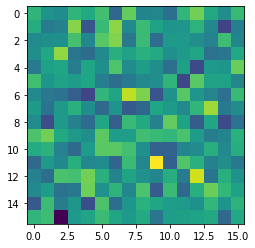

In [88]:
plt.imshow(x.numpy()[0, 0, 5, :, :])

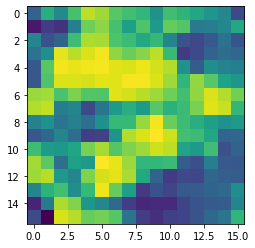

In [93]:
plt.imshow(y.detach().cpu().numpy()[0, 0, 5, :, :])

In [70]:
class TestKiUNetMod1(nn.Module):
    # copy their KiUnet and then move on to other baseline models, 
    # and try to get a model from one of the papers with code top models.
    
    def __init__(self, encoder_layers=[16,32,64], decoder_layers=[32,16,8], 
                 encoderf1_layers=[16,32,64], decoderf1_layers=[32,16,8], 
                 intere_layers=[16,32,64], interd_layers=[32,16],
                         in_channels=3, out_channels=1, kernel_size=3, dropout_p=0.5):
        super().__init__()
        
        self.encoder_blocks = nn.ModuleList([
            SimpleBlock(ins, outs, kernel_size, dropout_p, False, max_pooling=True)
            for (ins, outs) in
            zip ([in_channels] + encoder_layers[:-1], encoder_layers)
        ])
        
        self.decoder_blocks = nn.ModuleList([
            SimpleBlock(ins, outs, kernel_size, dropout_p, True, max_pooling=False)
            for (ins, outs) in 
            zip([encoder_layers[-1]] + decoder_layers[:-1], decoder_layers)
        ])
        
        self.encoderf1_blocks = nn.ModuleList([
            SimpleBlock(ins, outs, kernel_size, dropout_p, True, max_pooling=False)
            for (ins, outs) in
            zip ([in_channels] + encoderf1_layers[:-1], encoderf1_layers)
        ])
        
        self.decoderf1_blocks = nn.ModuleList([
            SimpleBlock(ins, outs, kernel_size, dropout_p, False, max_pooling=True)
            for (ins, outs) in 
            zip([encoderf1_layers[-1]] + decoderf1_layers[:-1], decoderf1_layers)
        ])
        
        self.intere1_blocks = nn.ModuleList([
            SimpleBlock(ins, outs, kernel_size, dropout_p, False, max_pooling=False)
            for (ins, outs) in
            zip (intere_layers, intere_layers)
        ])
        
        self.intere2_blocks = nn.ModuleList([
            SimpleBlock(ins, outs, kernel_size, dropout_p, False, max_pooling=False)
            for (ins, outs) in
            zip (intere_layers, intere_layers)
        ])
        
        self.interd1_blocks = nn.ModuleList([
            SimpleBlock(ins, outs, kernel_size, dropout_p, False, max_pooling=False)
            for (ins, outs) in
            zip (interd_layers, interd_layers)
        ])
        
        self.interd2_blocks = nn.ModuleList([
            SimpleBlock(ins, outs, kernel_size, dropout_p, False, max_pooling=False)
            for (ins, outs) in
            zip (interd_layers, interd_layers)
        ])
        
        self.final_conv = nn.Conv2d(8, out_channels=2, kernel_size=1, stride=1, padding=0)
        self.soft = nn.Softmax(dim=1)
        
        
    def forward(self, x):
        
        unet_out = x
        kinet_out = x
        skip_conns_stack = []
        scale_factor = 1
        
        # print("0")
        # print("unet out shape:  ", unet_out.shape)
        # print("kinet out shape: ", kinet_out.shape)
        # print("------------------\n")
        
        
        # encoder path
        num_blocks = len(self.encoder_blocks)
        for l in range(num_blocks):
            # standard forward pass for both paths
            unet_out = self.encoder_blocks[l](unet_out)
            kinet_out = self.encoderf1_blocks[l](kinet_out)
            
            tmp = unet_out
            
            # print(l+1)
            # print("unet out shape:  ", unet_out.shape)
            # print("kinet out shape: ", kinet_out.shape)
            # print("------------------\n")
            
            # CRFB block
            scale_factor *= 4.
            crfb1 = self.intere1_blocks[l](kinet_out)
            # print("crfb1 shape: ", crfb1.shape)
            unet_out = torch.add(
                unet_out,
                F.interpolate(crfb1, scale_factor=1./scale_factor, mode='bilinear')
            )
            # print("post crfb unet out shape:  ", unet_out.shape)
            
            crfb2 = self.intere2_blocks[l](tmp)
            # print("crfb2 shape: ", crfb2.shape)
            kinet_out = torch.add(
                kinet_out,
                F.interpolate(crfb2, scale_factor=scale_factor,mode='bilinear')
            )
            # print("post crfb kinet out shape: ", kinet_out.shape)
            
            # append skip connections
            if l != num_blocks - 1:
                skip_conns_stack.append((unet_out, kinet_out))
            
            
        # print("\nstack shapes:   ")
        # for pair in skip_conns_stack:
        #     print(pair[0].shape, pair[1].shape)
        # print("\n")
            
            
        # decoder path
        # print("--------------")
        # print("decoder path: ")
        for l in range(len(self.decoder_blocks)):
            # standard forward pass for both paths
            unet_out = self.decoder_blocks[l](unet_out)
            kinet_out = self.decoderf1_blocks[l](kinet_out)
            
            # print(l+1)
            # print("unet out shape:  ", unet_out.shape)
            # print("kinet out shape: ", kinet_out.shape)
            # print("------------------\n")
            
            tmp = unet_out
            
            # CRFB block
            if l != num_blocks - 1:
                scale_factor /= 4.
                crfb1 = self.interd1_blocks[l](kinet_out)
                # print("crfb1 shape: ", crfb1.shape)
                unet_out = torch.add(
                    unet_out,
                    F.interpolate(crfb1, scale_factor=1./scale_factor, mode='bilinear')
                )
                # print("post crfb unet out shape:  ", unet_out.shape)

                crfb2 =self.interd2_blocks[l](tmp)
                # print("crfb2 shape: ", crfb1.shape)
                kinet_out = torch.add(
                    kinet_out,
                    F.interpolate(crfb2, scale_factor=scale_factor, mode='bilinear')
                )
                # print("post crfb kinet out shape: ", kinet_out.shape)
            
            # add skip connections
            if l != num_blocks - 1:
                unet_skipc, kinet_skipc = skip_conns_stack.pop() # pop implements LIFO stack behaviour
                # print("skip unet shape:  ", unet_skipc.shape)
                # print("skip kinet shape: ", kinet_skipc.shape)
                unet_out = torch.add(unet_out, unet_skipc)
                kinet_out = torch.add(kinet_out, kinet_skipc)
            
            
            
        # fusion of both branches
        out = torch.add(unet_out, kinet_out)
        out = self.final_conv(out)
        out = self.soft(out)
        
        return out

In [57]:
kiunet = TestKiUNetMod1(in_channels=1)

In [58]:
#summary(kiunet)

In [59]:
summary(kiunet, (1, 1, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TestKiUNetMod1                           --                        --
├─ModuleList: 1-1                        --                        --
├─ModuleList: 1-2                        --                        --
├─ModuleList: 1-3                        --                        --
├─ModuleList: 1-4                        --                        --
├─ModuleList: 1-5                        --                        --
├─ModuleList: 1-6                        --                        --
├─ModuleList: 1-7                        --                        --
├─ModuleList: 1-8                        --                        --
├─ModuleList: 1-1                        --                        --
│    └─SimpleBlock: 2-1                  [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 16, 64, 64]           160
│    │    └─BatchNorm2d: 3-2             [1, 16, 32, 32]           32
│    │    └─Dr

In [51]:
x = torch.rand(1,1,64,64)

In [29]:
with torch.no_grad():
    y = kiunet(x.to("cuda")).cpu()

0
unet out shape:   torch.Size([1, 1, 64, 64])
kinet out shape:  torch.Size([1, 1, 64, 64])
------------------

1
unet out shape:   torch.Size([1, 16, 32, 32])
kinet out shape:  torch.Size([1, 16, 128, 128])
------------------

crfb1 shape:  torch.Size([1, 16, 128, 128])
post crfb unet out shape:   torch.Size([1, 16, 32, 32])
crfb2 shape:  torch.Size([1, 16, 32, 32])
post crfb kinet out shape:  torch.Size([1, 16, 128, 128])
2
unet out shape:   torch.Size([1, 32, 16, 16])
kinet out shape:  torch.Size([1, 32, 256, 256])
------------------

crfb1 shape:  torch.Size([1, 32, 256, 256])
post crfb unet out shape:   torch.Size([1, 32, 16, 16])
crfb2 shape:  torch.Size([1, 32, 16, 16])
post crfb kinet out shape:  torch.Size([1, 32, 256, 256])
3
unet out shape:   torch.Size([1, 64, 8, 8])
kinet out shape:  torch.Size([1, 64, 512, 512])
------------------

crfb1 shape:  torch.Size([1, 64, 512, 512])
post crfb unet out shape:   torch.Size([1, 64, 8, 8])
crfb2 shape:  torch.Size([1, 64, 8, 8])
post

In [30]:
y.shape

torch.Size([1, 1, 64, 64])

In [40]:
class Kiunet(nn.Module):
    
    def __init__(self):
        super().__init__()
        

        self.encoder1 = nn.Conv2d(1, 16, 3, stride=1, padding=1)  # First Layer GrayScale Image , change to input channels to 3 in case of RGB 
        self.en1_bn = nn.BatchNorm2d(16)
        self.encoder2=   nn.Conv2d(16, 32, 3, stride=1, padding=1)  
        self.en2_bn = nn.BatchNorm2d(32)
        self.encoder3=   nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.en3_bn = nn.BatchNorm2d(64)

        self.decoder1 =   nn.Conv2d(64, 32, 3, stride=1, padding=1)   
        self.de1_bn = nn.BatchNorm2d(32)
        self.decoder2 =   nn.Conv2d(32,16, 3, stride=1, padding=1)
        self.de2_bn = nn.BatchNorm2d(16)
        self.decoder3 =   nn.Conv2d(16, 8, 3, stride=1, padding=1)
        self.de3_bn = nn.BatchNorm2d(8)

        self.decoderf1 =   nn.Conv2d(64, 32, 3, stride=1, padding=1)
        self.def1_bn = nn.BatchNorm2d(32)
        self.decoderf2=   nn.Conv2d(32, 16, 3, stride=1, padding=1)
        self.def2_bn = nn.BatchNorm2d(16)
        self.decoderf3 =   nn.Conv2d(16, 8, 3, stride=1, padding=1)
        self.def3_bn = nn.BatchNorm2d(8)

        self.encoderf1 =   nn.Conv2d(1, 16, 3, stride=1, padding=1)  # First Layer GrayScale Image , change to input channels to 3 in case of RGB 
        self.enf1_bn = nn.BatchNorm2d(16)
        self.encoderf2=   nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.enf2_bn = nn.BatchNorm2d(32)
        self.encoderf3 =   nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.enf3_bn = nn.BatchNorm2d(64)

        self.intere1_1 = nn.Conv2d(16,16,3, stride=1, padding=1)
        self.inte1_1bn = nn.BatchNorm2d(16)
        self.intere2_1 = nn.Conv2d(32,32,3, stride=1, padding=1)
        self.inte2_1bn = nn.BatchNorm2d(32)
        self.intere3_1 = nn.Conv2d(64,64,3, stride=1, padding=1)
        self.inte3_1bn = nn.BatchNorm2d(64)

        self.intere1_2 = nn.Conv2d(16,16,3, stride=1, padding=1)
        self.inte1_2bn = nn.BatchNorm2d(16)
        self.intere2_2 = nn.Conv2d(32,32,3, stride=1, padding=1)
        self.inte2_2bn = nn.BatchNorm2d(32)
        self.intere3_2 = nn.Conv2d(64,64,3, stride=1, padding=1)
        self.inte3_2bn = nn.BatchNorm2d(64)

        self.interd1_1 = nn.Conv2d(32,32,3, stride=1, padding=1)
        self.intd1_1bn = nn.BatchNorm2d(32)
        self.interd2_1 = nn.Conv2d(16,16,3, stride=1, padding=1)
        self.intd2_1bn = nn.BatchNorm2d(16)
        self.interd3_1 = nn.Conv2d(64,64,3, stride=1, padding=1)
        self.intd3_1bn = nn.BatchNorm2d(64)

        self.interd1_2 = nn.Conv2d(32,32,3, stride=1, padding=1)
        self.intd1_2bn = nn.BatchNorm2d(32)
        self.interd2_2 = nn.Conv2d(16,16,3, stride=1, padding=1)
        self.intd2_2bn = nn.BatchNorm2d(16)
        self.interd3_2 = nn.Conv2d(64,64,3, stride=1, padding=1)
        self.intd3_2bn = nn.BatchNorm2d(64)

        self.final = nn.Conv2d(8,2,1,stride=1,padding=0)
        
        self.soft = nn.Softmax(dim =1)
    
    def forward(self, x):

        out = F.relu(self.en1_bn(F.max_pool2d(self.encoder1(x),2,2)))  #U-Net branch
        out1 = F.relu(self.enf1_bn(F.interpolate(self.encoderf1(x),scale_factor=(2,2),mode ='bilinear'))) #Ki-Net branch
        tmp = out
        out = torch.add(out,F.interpolate(F.relu(self.inte1_1bn(self.intere1_1(out1))),scale_factor=(0.25,0.25),mode ='bilinear')) #CRFB
        out1 = torch.add(out1,F.interpolate(F.relu(self.inte1_2bn(self.intere1_2(tmp))),scale_factor=(4,4),mode ='bilinear')) #CRFB
        
        u1 = out  #skip conn
        o1 = out1  #skip conn

        out = F.relu(self.en2_bn(F.max_pool2d(self.encoder2(out),2,2)))
        out1 = F.relu(self.enf2_bn(F.interpolate(self.encoderf2(out1),scale_factor=(2,2),mode ='bilinear')))
        tmp = out
        out = torch.add(out,F.interpolate(F.relu(self.inte2_1bn(self.intere2_1(out1))),scale_factor=(0.0625,0.0625),mode ='bilinear'))
        out1 = torch.add(out1,F.interpolate(F.relu(self.inte2_2bn(self.intere2_2(tmp))),scale_factor=(16,16),mode ='bilinear'))
        
        u2 = out
        o2 = out1

        out = F.relu(self.en3_bn(F.max_pool2d(self.encoder3(out),2,2)))
        out1 = F.relu(self.enf3_bn(F.interpolate(self.encoderf3(out1),scale_factor=(2,2),mode ='bilinear')))
        tmp = out
        out = torch.add(out,F.interpolate(F.relu(self.inte3_1bn(self.intere3_1(out1))),scale_factor=(0.015625,0.015625),mode ='bilinear'))
        out1 = torch.add(out1,F.interpolate(F.relu(self.inte3_2bn(self.intere3_2(tmp))),scale_factor=(64,64),mode ='bilinear'))
        
        ### End of encoder block

        ### Start Decoder
        print("unet shape", out.shape)
        print("kinet shape", out1.shape)
        
        out = F.relu(self.de1_bn(F.interpolate(self.decoder1(out),scale_factor=(2,2),mode ='bilinear')))  #U-NET
        out1 = F.relu(self.def1_bn(F.max_pool2d(self.decoderf1(out1),2,2))) #Ki-NET
        print("\nunet shape step 1", out.shape)
        print("kinet shape step 1", out1.shape)
        tmp = out
        out = torch.add(out,F.interpolate(F.relu(self.intd1_1bn(self.interd1_1(out1))),scale_factor=(0.0625,0.0625),mode ='bilinear'))
        out1 = torch.add(out1,F.interpolate(F.relu(self.intd1_2bn(self.interd1_2(tmp))),scale_factor=(16,16),mode ='bilinear'))
        print("\nunet shape crfb 1", out.shape)
        print("kinet shape crfb 1", out1.shape)
        
        out = torch.add(out,u2)  #skip conn
        out1 = torch.add(out1,o2)  #skip conn

        out = F.relu(self.de2_bn(F.interpolate(self.decoder2(out),scale_factor=(2,2),mode ='bilinear')))
        out1 = F.relu(self.def2_bn(F.max_pool2d(self.decoderf2(out1),2,2)))
        tmp = out
        out = torch.add(out,F.interpolate(F.relu(self.intd2_1bn(self.interd2_1(out1))),scale_factor=(0.25,0.25),mode ='bilinear'))
        out1 = torch.add(out1,F.interpolate(F.relu(self.intd2_2bn(self.interd2_2(tmp))),scale_factor=(4,4),mode ='bilinear'))
        
        out = torch.add(out,u1)
        out1 = torch.add(out1,o1)

        out = F.relu(self.de3_bn(F.interpolate(self.decoder3(out),scale_factor=(2,2),mode ='bilinear')))
        out1 = F.relu(self.def3_bn(F.max_pool2d(self.decoderf3(out1),2,2)))

        

        out = torch.add(out,out1) # fusion of both branches

        out = F.relu(self.final(out))  #1*1 conv
        

        # out = self.soft(out)
        
        return out


In [41]:
kiu = Kiunet()

In [42]:
summary(kiu, (4, 1, 128, 128))

unet shape torch.Size([4, 64, 16, 16])
kinet shape torch.Size([4, 64, 1024, 1024])

unet shape step 1 torch.Size([4, 32, 32, 32])
kinet shape step 1 torch.Size([4, 32, 512, 512])

unet shape crfb 1 torch.Size([4, 32, 32, 32])
kinet shape crfb 1 torch.Size([4, 32, 512, 512])


Layer (type:depth-idx)                   Output Shape              Param #
Kiunet                                   --                        --
├─Conv2d: 1-1                            [4, 16, 128, 128]         160
├─BatchNorm2d: 1-2                       [4, 16, 64, 64]           32
├─Conv2d: 1-3                            [4, 16, 128, 128]         160
├─BatchNorm2d: 1-4                       [4, 16, 256, 256]         32
├─Conv2d: 1-5                            [4, 16, 256, 256]         2,320
├─BatchNorm2d: 1-6                       [4, 16, 256, 256]         32
├─Conv2d: 1-7                            [4, 16, 64, 64]           2,320
├─BatchNorm2d: 1-8                       [4, 16, 64, 64]           32
├─Conv2d: 1-9                            [4, 32, 64, 64]           4,640
├─BatchNorm2d: 1-10                      [4, 32, 32, 32]           64
├─Conv2d: 1-11                           [4, 32, 256, 256]         4,640
├─BatchNorm2d: 1-12                      [4, 32, 512, 512]         64
├